In [15]:
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.manifold import TSNE

### Dataset

In [2]:
root_dir = "./data"

nii_files = glob(os.path.join(root_dir, "**", "*.nii.gz"), recursive=True)

records = []

for f in sorted(nii_files):
    img = nib.load(f)
    dataobj = img.dataobj
    
    shape = dataobj.shape
    
    # take middle slice along z-axis
    if len(shape) == 3:  # 3D scan
        slice_img = dataobj[:, :, shape[2] // 2]
    elif len(shape) == 4:  # 4D scan
        slice_img = dataobj[:, :, shape[2] // 2, 0]  # take first timepoint
    else:
        continue
    
    flat_slice = slice_img.flatten()
    
    records.append({
        "filename": os.path.basename(f),
        "folder": os.path.basename(os.path.dirname(f)),
        "shape": shape,
        "slice": flat_slice
    })

df = pd.DataFrame(records)

#metadata
metadata_file = os.path.join(root_dir, "UCSF-PDGM-metadata_v5.csv")

metadata_df = pd.read_csv(metadata_file)

print(metadata_df.head())
print(f"\nTotal metadata entries: {len(metadata_df)}")
print(df.head())
print(f"\nTotal files processed: {len(df)}")

              ID Sex  Age at MRI  WHO CNS Grade  \
0  UCSF-PDGM-004   M          66              4   
1  UCSF-PDGM-005   F          80              4   
2  UCSF-PDGM-007   M          70              4   
3  UCSF-PDGM-008   M          70              4   
4  UCSF-PDGM-009   F          68              4   

  Final pathologic diagnosis (WHO 2021)    MGMT status MGMT index   1p/19q  \
0            Glioblastoma, IDH-wildtype       negative          0  unknown   
1            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
2            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
3            Glioblastoma, IDH-wildtype       negative          0  unknown   
4            Glioblastoma, IDH-wildtype       negative          0  unknown   

        IDH  1-dead 0-alive      OS     EOR Biopsy prior to imaging  \
0  wildtype               1  1303.0     STR                      No   
1  wildtype               1   274.0  biopsy                      No   
2  wildtype

In [3]:
df

,filename,folder,shape,slice
0,UCSF-PDGM-0231_ADC.nii.gz,UCSF-PDGM-0231_nifti,"(240, 240, 155)","[-0.028824858367443085, -0.028824858367443085,..."
1,UCSF-PDGM-0231_ASL.nii.gz,UCSF-PDGM-0231_nifti,"(240, 240, 155)","[-0.0008807862177491188, -0.000880786217749118..."
2,UCSF-PDGM-0231_DTI_eddy_FA.nii.gz,UCSF-PDGM-0231_nifti,"(240, 240, 155)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,UCSF-PDGM-0231_DTI_eddy_L1.nii.gz,UCSF-PDGM-0231_nifti,"(240, 240, 155)","[2.3871336907177465e-08, 2.3871336907177465e-0..."
4,UCSF-PDGM-0231_DTI_eddy_L2.nii.gz,UCSF-PDGM-0231_nifti,"(240, 240, 155)","[-1.9668050299515016e-08, -1.9668050299515016e..."
...,...,...,...,...
2272,UCSF-PDGM-0540_T2.nii.gz,UCSF-PDGM-0540_nifti,"(240, 240, 155)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2273,UCSF-PDGM-0540_T2_bias.nii.gz,UCSF-PDGM-0540_nifti,"(240, 240, 155)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2274,UCSF-PDGM-0540_brain_parenchyma_segmentation.n...,UCSF-PDGM-0540_nifti,"(240, 240, 155)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2275,UCSF-PDGM-0540_brain_segmentation.nii.gz,UCSF-PDGM-0540_nifti,"(240, 240, 155)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
metadata_df

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,UCSF-PDGM-537,M,64,4,"Glioblastoma, IDH-wildtype",positive,16,intact,wildtype,0,334.0,biopsy,Yes,NaN,NaN,NaN
497,UCSF-PDGM-538,F,41,4,"Glioblastoma, IDH-wildtype",negative,0,intact,wildtype,0,287.0,GTR,No,NaN,NaN,NaN
498,UCSF-PDGM-539,M,72,4,"Glioblastoma, IDH-wildtype",positive,12,intact,wildtype,0,291.0,GTR,No,NaN,NaN,NaN
499,UCSF-PDGM-540,F,70,2,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",positive,17,co-deletion,IDH1 p.R132H,0,215.0,STR,No,NaN,NaN,NaN


In [5]:
grade_2_3_df = metadata_df[metadata_df["WHO CNS Grade"].isin([2, 3])]
ids_grade_2_3 = [id_str.split('-')[-1] for id_str in grade_2_3_df["ID"].tolist()]

# extract 1p/19q mutation status
mutation_status = grade_2_3_df["1p/19q"].tolist()
sample_to_status = dict(zip(ids_grade_2_3, mutation_status))

print(f"Total samples in dict: {len(sample_to_status)}")
print("First 10 entries:")
for k, v in list(sample_to_status.items())[:10]:
    print(k, "->", v)

Total samples in dict: 99
First 10 entries:
231 -> intact
232 -> intact
233 -> intact
234 -> intact
235 -> intact
236 -> co-deletion
237 -> intact
238 -> intact
239 -> co-deletion
240 -> intact


### Model

In [ ]:
# -------------------------------
# 1. DATASET
# -------------------------------
class ROIDataset(Dataset):
    def __init__(self, roi_slices, labels):
        """
        roi_slices: list of numpy arrays of shape (H, W)
        labels: list or array of class labels (2 or 3)
        """
        self.data = [torch.tensor(s, dtype=torch.float32).unsqueeze(0) for s in roi_slices]  # add channel dim
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------------
# 2. Autoencoder
# -------------------------------
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> 16×120×120
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> 32×60×60
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> 64×30×30
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# -> 128×15×15
            nn.ReLU(),
            nn.Flatten(),  # -> 128 * 15 * 15 = 28800
            nn.Linear(128 * 15 * 15, latent_dim)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 15 * 15),
            nn.Unflatten(1, (128, 15, 15)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 64×30×30
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32×60×60
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16×120×120
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 1×240×240
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# -------------------------------
# 3. TRAINING
# -------------------------------
def train(model, dataloader, n_epochs=20, lr=1e-3, weight_decay=1e-5, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    for epoch in range(n_epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(dataloader.dataset):.6f}")

# -------------------------------
# 4. FEATURE EXTRACTION
# -------------------------------
def extract_features(model, roi_slices, device='cpu'):
    model.eval()
    features = []
    with torch.no_grad():
        for s in roi_slices:
            x = torch.tensor(s, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            _, z = model(x)
            features.append(z.cpu().numpy().flatten())
    return np.array(features)

In [7]:
status_to_int = {
    "unknown": 0,
    "relative co-deletion": 1,
    "co-deletion": 1,
    "intact": 2
}

roi_slices = []
labels = []

for sample_id in ids_grade_2_3:
    if sample_id not in sample_to_status:
        print(f"Sample {sample_id} not found in mutation dict.")
        continue

    status_str = sample_to_status[sample_id].strip().lower()
    if status_str not in status_to_int:
        print(f"Skipping sample {sample_id}: unknown status '{status_str}'")
        continue

    label = status_to_int[status_str]

    folder_path = os.path.join(root_dir, f"UCSF-PDGM-0{sample_id}_nifti")
    t2_file = os.path.join(folder_path, f"UCSF-PDGM-0{sample_id}_T2.nii.gz")
    seg_file = os.path.join(folder_path, f"UCSF-PDGM-0{sample_id}_tumor_segmentation.nii.gz")

    if not os.path.exists(t2_file) or not os.path.exists(seg_file):
        print(f"Missing files for sample {sample_id}, skipping.")
        continue

    t2_img = nib.load(t2_file).get_fdata()
    seg_img = nib.load(seg_file).get_fdata()
    num_slices = t2_img.shape[2]

    # collect only slices with tumor and statistically significant ROI
    for z in range(num_slices):
        t2_slice = t2_img[:, :, z]
        seg_slice = seg_img[:, :, z]
        roi = t2_slice * (seg_slice > 0)

        # skip slices with no tumor
        if np.sum(roi) == 0:
            continue

        mean_val = roi[roi > 0].mean() if np.any(roi > 0) else 0
        std_val = roi[roi > 0].std() if np.any(roi > 0) else 0
        frac_nonzero = np.count_nonzero(roi) / roi.size

        if mean_val < 0.01:   # dark slice
            continue
        if std_val < 0.01:    # uniform slices
            continue
        if frac_nonzero < 0.001:  # few pixels
            continue

        roi_slices.append(roi.astype(np.float32))
        labels.append(label)

print(f"Collected {len(roi_slices)} ROI slices and {len(labels)} labels")
assert len(roi_slices) == len(labels), "Mismatch between ROI and label count!"

Collected 4778 ROI slices and 4778 labels


In [8]:
def plot_T2_slices(root_dir, ids_list, num_examples=9, cols=3, alpha=0.4, figsize_per_plot=5):

    ids_to_plot = random.sample(ids_list, num_examples)
    rows = math.ceil(len(ids_to_plot) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_plot*cols, figsize_per_plot*rows))
    axes = axes.flatten()

    for i, sample_id in enumerate(ids_to_plot):

        folder_name = f"UCSF-PDGM-0{sample_id}_nifti"
        folder_path = os.path.join(root_dir, folder_name)

        t2_file = os.path.join(folder_path, f"UCSF-PDGM-0{sample_id}_T2.nii.gz")
        seg_file = os.path.join(folder_path, f"UCSF-PDGM-0{sample_id}_tumor_segmentation.nii.gz")

        if not os.path.exists(t2_file) or not os.path.exists(seg_file):
            print(f"Skipping {sample_id}: missing T2 or segmentation")
            axes[i].axis("off")
            continue

        t2_img = nib.load(t2_file).dataobj
        seg_img = nib.load(seg_file).dataobj

        # middle slice along z-axis
        t2_slice = t2_img[:, :, t2_img.shape[2] // 2]
        seg_slice = seg_img[:, :, seg_img.shape[2] // 2]

        # plot with overlay
        axes[i].imshow(t2_slice.T, cmap="gray", origin="lower")
        axes[i].imshow(seg_slice.T, cmap="Reds", alpha=alpha, origin="lower")
        axes[i].set_title(f"Sample {sample_id}")
        axes[i].axis("off")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
# Grade 2
grade_2_df = metadata_df[metadata_df["WHO CNS Grade"] == 2]
ids_grade_2 = [id_str.split('-')[-1] for id_str in grade_2_df["ID"].tolist()]
print(f"Grade 2 samples: {len(ids_grade_2)}")
print(ids_grade_2[:10])

# Grade 3
grade_3_df = metadata_df[metadata_df["WHO CNS Grade"] == 3]
ids_grade_3 = [id_str.split('-')[-1] for id_str in grade_3_df["ID"].tolist()]
print(f"Grade 3 samples: {len(ids_grade_3)}")
print(ids_grade_3[:10])

Grade 2 samples: 56
['232', '233', '234', '235', '236', '237', '238', '239', '240', '242']
Grade 3 samples: 43
['231', '241', '243', '249', '251', '254', '262', '263', '268', '272']


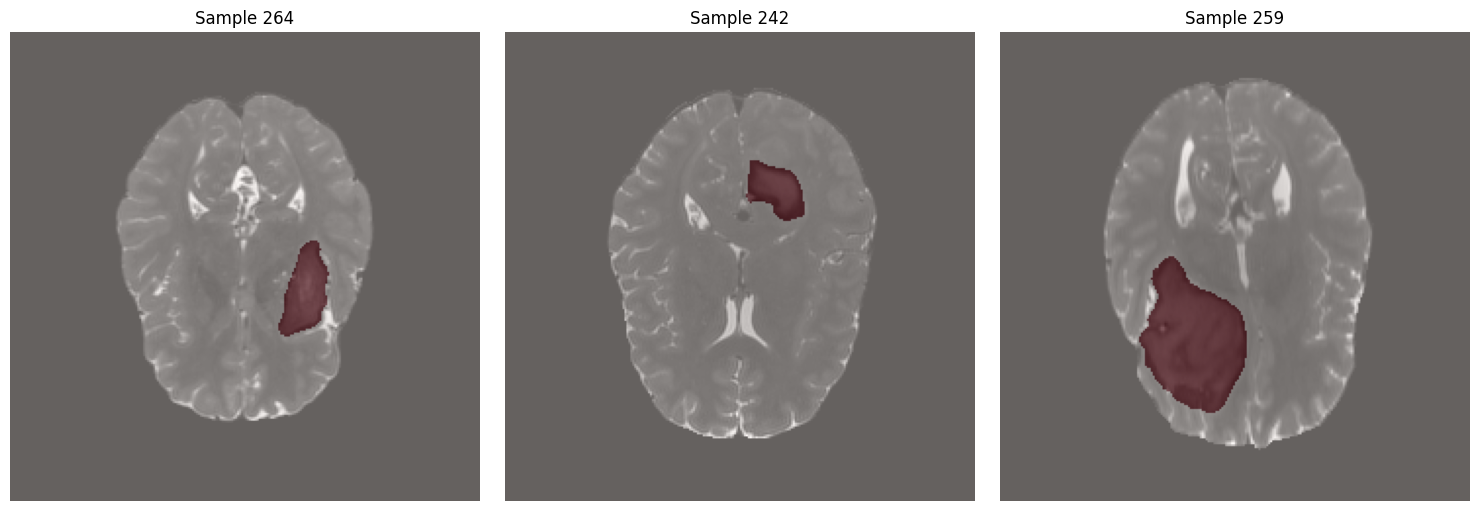

In [10]:
plot_T2_slices(root_dir, ids_grade_2, num_examples=3, cols=3)

### Train

In [11]:
# -------------------------------
# 1. Normalize
# -------------------------------
roi_slices_norm = []
for s in roi_slices:
    min_val = s.min()
    max_val = s.max()
    if max_val > min_val:
        s_norm = (s - min_val) / (max_val - min_val)
    else:
        s_norm = s  # already constant slice
    roi_slices_norm.append(s_norm)

# -------------------------------
# 2. Create Dataset and DataLoader
# -------------------------------
dataset = ROIDataset(roi_slices_norm, labels)

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 3. Check shapes
# -------------------------------
for x, y in dataloader:
    print("Batch x shape:", x.shape)  # (batch_size, 1, H, W)
    print("Batch y shape:", y.shape)  # (batch_size,)
    break

Batch x shape: torch.Size([16, 1, 240, 240])
Batch y shape: torch.Size([16])


Epoch 1/5, Loss: 0.040566
Epoch 2/5, Loss: 0.008897
Epoch 3/5, Loss: 0.008556
Epoch 4/5, Loss: 0.007652
Epoch 5/5, Loss: 0.003504


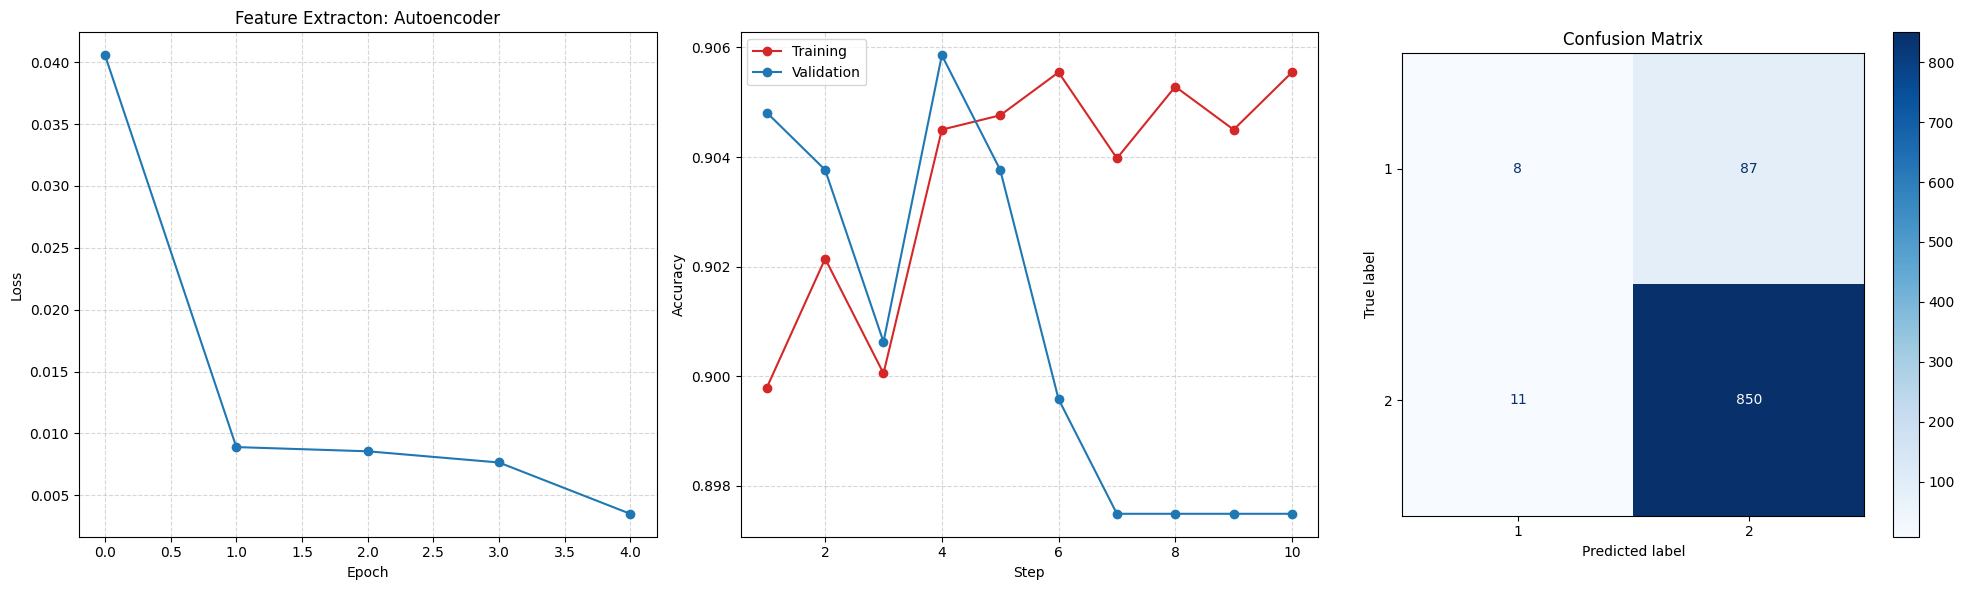

In [12]:
# -------------------------------
# Parameters
# -------------------------------
latent_dim = 28
batch_size = 16
n_epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# 1. Autoencoder
# -------------------------------
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

# -------------------------------
# 2. DataLoader
# -------------------------------
dataloader = DataLoader(ROIDataset(roi_slices_norm, labels), batch_size=batch_size, shuffle=True)

# -------------------------------
# 3. Train Autoencoder
# -------------------------------

def train_autoencoder(model, dataloader, n_epochs=20, lr=1e-3, weight_decay=1e-5, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    train_losses = []

    for epoch in range(n_epochs):
        total_loss = 0
        model.train()
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")
    return train_losses

train_losses = train_autoencoder(autoencoder, dataloader, n_epochs=n_epochs, lr=1e-4, weight_decay=1e-5, device=device)

# -------------------------------
# 4. Extract Latent Features
# -------------------------------
features_ae = extract_features(autoencoder, roi_slices_norm, device=device)
labels_np = np.array(labels)

# -------------------------------
# 5. Split Train/Validation
# -------------------------------
X_train_ae, X_val_ae, y_train, y_val = train_test_split(
    features_ae, labels_np, test_size=0.2, stratify=labels_np, random_state=42
)

# -------------------------------
# 6. Train AE Classifier
# -------------------------------
clf_ae = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver="lbfgs"))

train_accs_ae, val_accs_ae = [], []
n_steps = 10
chunk_size_ae = len(X_train_ae) // n_steps

for i in range(1, n_steps + 1):
    clf_ae.fit(X_train_ae[:i * chunk_size_ae], y_train[:i * chunk_size_ae])
    train_accs_ae.append(clf_ae.score(X_train_ae, y_train))
    val_accs_ae.append(clf_ae.score(X_val_ae, y_val))

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
y_val_pred = clf_ae.predict(X_val_ae)
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(labels_np))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_np))

# -------------------------------
# 8. Plots
# -------------------------------
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# loss
axs[0].plot(train_losses, marker='o', color='tab:blue')
axs[0].set_title("Feature Extracton: Autoencoder")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle="--", alpha=0.5)

# accuracy
steps = np.arange(1, n_steps + 1)
axs[1].plot(steps, train_accs_ae, label="Training", marker='o', color='tab:red', linestyle='-')
axs[1].plot(steps, val_accs_ae, label="Validation", marker='o', color='tab:blue', linestyle='-')
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.5)

# confusion matrix
disp.plot(ax=axs[2], cmap="Blues", colorbar=True)
axs[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
# git repo until here

### Evaluation

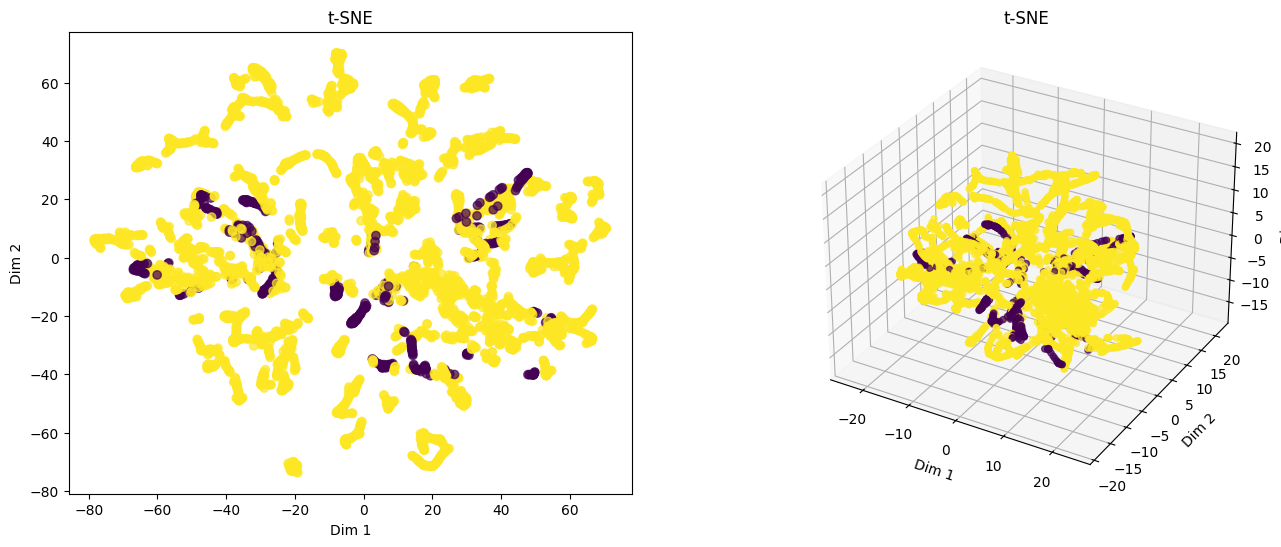

In [ ]:
tsne_2d = TSNE(n_components=2, random_state=42)
features_2d = tsne_2d.fit_transform(features_ae)
tsne_3d = TSNE(n_components=3, random_state=42)
features_3d = tsne_3d.fit_transform(features_ae)

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1, 2, 1)
scatter_2d = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_np, cmap='viridis', alpha=0.7)
ax1.set_title("t-SNE")
ax1.set_xlabel("Dim 1")
ax1.set_ylabel("Dim 2")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter_3d = ax2.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=labels_np, cmap='viridis', alpha=0.7)
ax2.set_title("t-SNE")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")
ax2.set_zlabel("Dim 3")

plt.show()

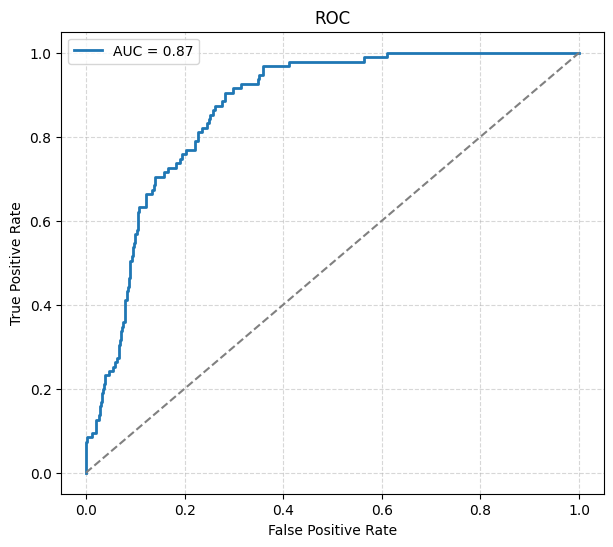

In [14]:
classes = np.unique(y_val)

target_class = classes[0]

y_val_bin = (y_val == target_class).astype(int)

y_val_proba = clf_ae.predict_proba(X_val_ae)
class_index = list(classes).index(target_class)
y_val_proba_cls = y_val_proba[:, class_index]

fpr, tpr, _ = roc_curve(y_val_bin, y_val_proba_cls)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(f"ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = Autoencoder(latent_dim=20).to(device)

# def train_autoencoder(model, dataloader, n_epochs=10, lr=1e-3, weight_decay=1e-5, device="cpu"):
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     criterion = torch.nn.MSELoss()
#     train_losses = []

#     for epoch in range(n_epochs):
#         model.train()
#         total_loss = 0
#         for x, _ in dataloader:
#             x = x.to(device)
#             optimizer.zero_grad()
#             x_recon, _ = model(x)
#             loss = criterion(x_recon, x)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item() * x.size(0)
#         avg_loss = total_loss / len(dataloader.dataset)
#         train_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{n_epochs}]  Train Loss: {avg_loss:.6f}")

#     return train_losses

# train_losses = train_autoencoder(autoencoder, dataloader, n_epochs=15, device=device)

features_ae = extract_features(autoencoder, roi_slices, device=device)  # (N, 128)
labels_np = np.array(labels)

X_train_ae, X_val_ae, y_train, y_val = train_test_split(
    features_ae, labels_np, test_size=0.2, stratify=labels_np, random_state=42
)

# Prepare flattened raw ROI features (no autoencoder)
roi_flat = np.array([roi.flatten() for roi in roi_slices])
X_train_raw, X_val_raw, _, _ = train_test_split(
    roi_flat, labels_np, test_size=0.2, stratify=labels_np, random_state=42
)

# -------------------------------
# D. CLASSIFIER
# -------------------------------
clf_ae = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver="lbfgs"))
clf_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver="lbfgs"))

train_accs_ae, val_accs_ae = [], []
train_accs_raw, val_accs_raw = [], []

n_steps = 10
chunk_size = len(X_train_ae) // n_steps

for i in range(1, n_steps + 1):
    # AE features
    clf_ae.fit(X_train_ae[:i * chunk_size], y_train[:i * chunk_size])
    train_accs_ae.append(clf_ae.score(X_train_ae, y_train))
    val_accs_ae.append(clf_ae.score(X_val_ae, y_val))
    
    # Raw features
    clf_raw.fit(X_train_raw[:i * chunk_size], y_train[:i * chunk_size])
    train_accs_raw.append(clf_raw.score(X_train_raw, y_train))
    val_accs_raw.append(clf_raw.score(X_val_raw, y_val))

print(f"Training Accuracy (w/ AE): {train_accs_ae[-1]:.4f}")
print(f"Validation Accuracy (w/ AE): {val_accs_ae[-1]:.4f}")
print(f"Training Accuracy (w/o AE): {train_accs_raw[-1]:.4f}")
print(f"Validation Accuracy (w/o AE): {val_accs_raw[-1]:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- loss ---
ax[0].plot(train_losses, marker='o', color='tab:blue')
ax[0].set_title("Feature Extraction: Autoencoder")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("MSE")

# --- accuracy ---
ax[1].plot(train_accs_ae, label="Training (w/ AE)", marker='o', color='tab:red', linestyle='-')
ax[1].plot(val_accs_ae, label="Validation (w/ AE)", marker='o', color='tab:blue', linestyle='-')

ax[1].plot(train_accs_raw, label="Training (w/o AE)", marker='^', color='tab:red', linestyle='--')
ax[1].plot(val_accs_raw, label="Validation (w/o AE)", marker='^', color='tab:blue', linestyle='--')

ax[1].set_title("Classifier: Logistic Regression")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()